# Week 1

* **Pre-Training**: `tangency-portfolio`
* **Market Simulation**: baseline models
* **Environment**: observation & OpenAI new API

In [1]:
import qtrader

import datetime

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-muted')
plt.style.use('seaborn-ticks')
plt.style.use('seaborn-poster')

import warnings
warnings.filterwarnings('ignore')

/Users/alpha/Developer/qtrader/.env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Data Source

In [2]:
# three-years window
start_date = datetime.date.today() - datetime.timedelta(days=3*365)

# trading period
freq = 'W'

# stock tickers
TICKERS = ['AAPL', 'GE', 'JPM', 'GOOG', 'MSFT', 'VOD', 'GS', 'TSLA']

# prices
prices = qtrader.envs.data_loader.Finance.Prices(tickers=TICKERS,
                                                 source='quandl',
                                                 start_date=start_date,
                                                 freq=freq)

# returns
returns = qtrader.envs.data_loader.Finance.Returns(tickers=TICKERS,
                                                   source='quandl',
                                                   start_date=start_date,
                                                   freq=freq)

# log-returns
rhos = np.log(1 + returns)

### Empirical Estimators

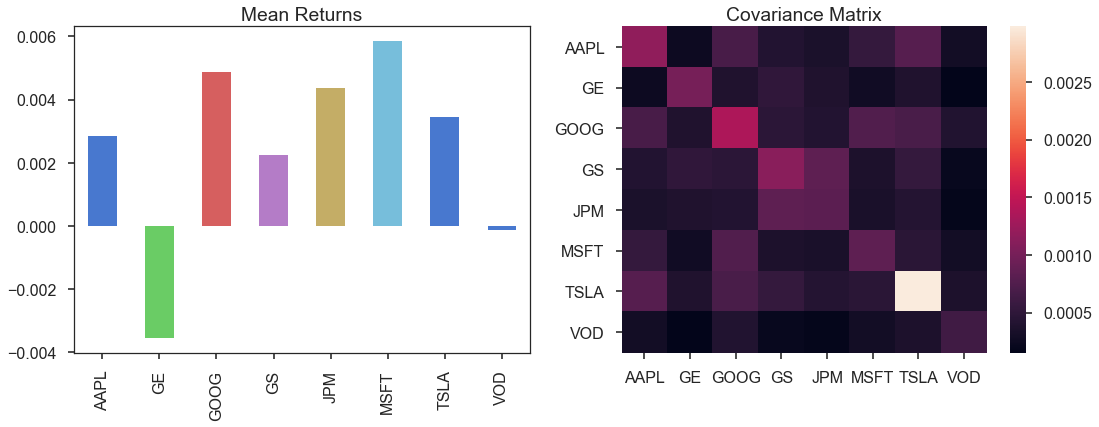

In [3]:
# mean returns
mu_r = returns.mean()
# returns covariance
Sigma_r = returns.cov()

fig, axes = plt.subplots(ncols=2, figsize=(18.0, 6.0))

mu_r.plot.bar(ax=axes[0])
axes[0].set_title('Mean Returns')

sns.heatmap(Sigma_r, ax=axes[1])
axes[1].set_title('Covariance Matrix');

## Risk Averse Portfolio with Transaction Costs

Determine portfolio vector $\mathbf{w}$, such that:

\begin{aligned}
& \underset{\mathbf{w}}{\text{maximize}}
& & \mathbf{w}^{T} \mathbf{r} -
    \alpha \mathbf{w}^{T} \boldsymbol{\Sigma} \mathbf{w} -
    \mathbf{1}^{T} \beta \|(\mathbf{w_{0}} - \mathbf{w})\| & \text{ (utility function) } \\
& \text{subject to}
& & \mathbf{w}^{T} \mathbf{1} = 1 & \text{ (budget constraint) } \\
&
& & 
\end{aligned}

where:

* $M$: number of assets in portfolio
* $\alpha \geq 0$: risk-aversion coefficient
* $\beta \geq 0$: transaction costs coefficient (i.e 0.0025)
* $\boldsymbol{\Sigma} \in \mathbb{R}^{M \times M}$: portfolio returns covariance
* $\mathbf{r} \in \mathbb{R}^{M}$: portfolio returns mean
* $\mathbf{w_{0}}$: initial portfolio weights

In [4]:
# objective function
J = qtrader.agents.pretrainer.objectives.risk_aversion

# uniform initial weights
w0 = np.ones_like(mu_r) / len(mu_r)

# range of alpha
alphas = np.linspace(0.001, 1000, 1000)

# transaction costs coefficient
beta = 0.0025
3
# caches
mus = np.empty_like(alphas)
sigmas = np.empty_like(alphas)
trans = np.empty_like(alphas)

# run experiments
for j, alpha in enumerate(alphas):
    # optimal weights
    wj = qtrader.agents.pretrainer.optimizer(J, alpha, beta)(mu_r, Sigma_r, w0)
    # portfolio expected mean returns
    mus[j] = qtrader.agents.pretrainer.objectives._mu_p(w=wj, r=mu_r)
    # portfolio expected variance
    sigmas[j] = qtrader.agents.pretrainer.objectives._sigma_p(w=wj, Sigma=Sigma_r)
    # transaction costs
    trans[j] = qtrader.agents.pretrainer.objectives._trans_costs(w=wj, coef=beta, w0=w0)

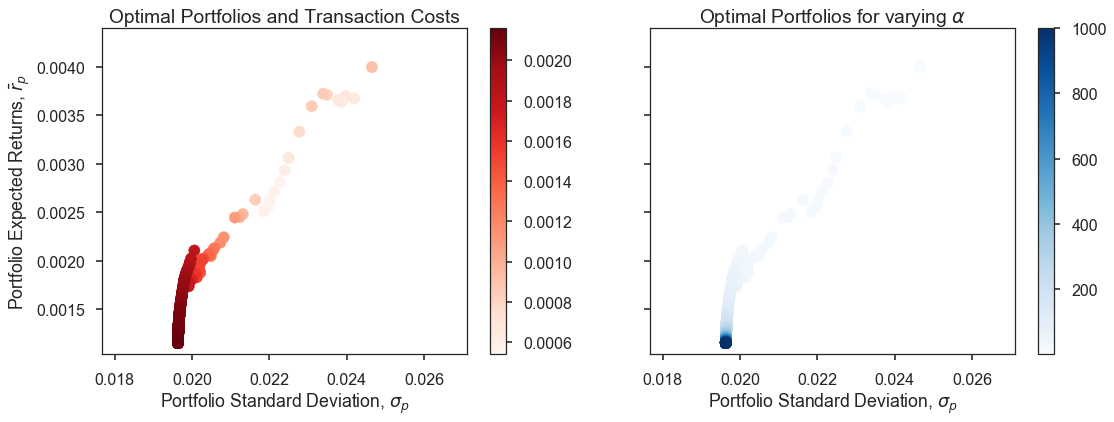

In [5]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(18.0, 6.0))
sc0 = axes[0].scatter(np.sqrt(sigmas), mus, c=trans, cmap=plt.cm.Reds)

axes[0].set_title('Optimal Portfolios and Transaction Costs')
axes[0].set_xlabel('Portfolio Standard Deviation, $\\sigma_{p}$')
axes[0].set_ylabel('Portfolio Expected Returns, $\\bar{r}_{p}$')
axes[0].set_ylim([mus.min() * 0.9, mus.max() * 1.1])
axes[0].set_xlim([np.sqrt(sigmas).min() * 0.9, np.sqrt(sigmas).max() * 1.1])
fig.colorbar(sc0, ax=axes[0])

sc1 = axes[1].scatter(np.sqrt(sigmas), mus, c=alphas, cmap=plt.cm.Blues)
axes[1].set_title('Optimal Portfolios for varying $\\alpha$')
axes[1].set_xlabel('Portfolio Standard Deviation, $\\sigma_{p}$')
axes[1].set_ylim([mus.min() * 0.9, mus.max() * 1.1])
axes[1].set_xlim([np.sqrt(sigmas).min() * 0.9, np.sqrt(sigmas).max() * 1.1])
fig.colorbar(sc1, ax=axes[1]);

## Tangency Portfolio with Transaction Costs

Determine portfolio vector $\mathbf{w}$, such that:

\begin{aligned}
& \underset{\mathbf{w}}{\text{maximize}}
& & \frac{\mathbf{w}^{T} \mathbf{r}}{\sqrt{\mathbf{w}^{T} \boldsymbol{\Sigma} \mathbf{w}}} -
    \mathbf{1}^{T} \gamma \|(\mathbf{w_{0}} - \mathbf{w})\| & \text{ (utility function) } \\
& \text{subject to}
& & \mathbf{w}^{T} \mathbf{1} = 1 & \text{ (budget constraint) } \\
&
& & 
\end{aligned}

where:

* $M$: number of assets in portfolio
* $\gamma \geq 0$: transaction costs coefficient
* $\boldsymbol{\Sigma} \in \mathbb{R}^{M \times M}$: portfolio returns covariance
* $\mathbf{r} \in \mathbb{R}^{M}$: portfolio returns mean
* $\mathbf{w_{0}}$: initial portfolio weights

In [6]:
# objective function
J = qtrader.agents.pretrainer.objectives.sharpe_ratio

# uniform initial weights
w0 = np.ones_like(mu_r) / len(mu_r)

# range of alpha
alphas = np.linspace(0.001, 1000, 1000)

# transaction costs coefficient
gamma = 0.5

w = qtrader.agents.pretrainer.optimizer(J, gamma)(mu_r, Sigma_r, w0)
# portfolio expected mean returns
mu = qtrader.agents.pretrainer.objectives._mu_p(w=w, r=mu_r)
# portfolio expected variance
sigma = qtrader.agents.pretrainer.objectives._sigma_p(w=w, Sigma=Sigma_r)
# transaction costs
trans = qtrader.agents.pretrainer.objectives._trans_costs(w=w, coef=beta, w0=w0)

(mu, sigma, trans)

(0.004631656137735586, 0.0005299985674858376, 0.003132133540584075)

## Market Simulation: Baseline Models

### Surrogates: Amplitude Adjusted Fourier Transform (AAFT)

Preserve first and second order statistical moments by:

1. Fourier Transformation of multivariate time-series
2. Randomisation of Phase
3. Inverse Fourier Transaformation

The identity of the autocorrelation functions is based on the fact that the original time series and the surrogate
have per construction the same power spectrum, which in turn is linked to the autocorrelation function via the
[Wiener–Khinchin theorem](https://en.wikipedia.org/wiki/Wiener%E2%80%93Khinchin_theorem).

In [7]:
# prices time-series generation
prices_gen = qtrader.envs.simulator.AAFT(prices.dropna().values, random=np.random.normal, random_state=13)

# returns time-series generation
returns_gen = qtrader.envs.simulator.AAFT(returns.dropna().values, random=np.random.normal, random_state=13)

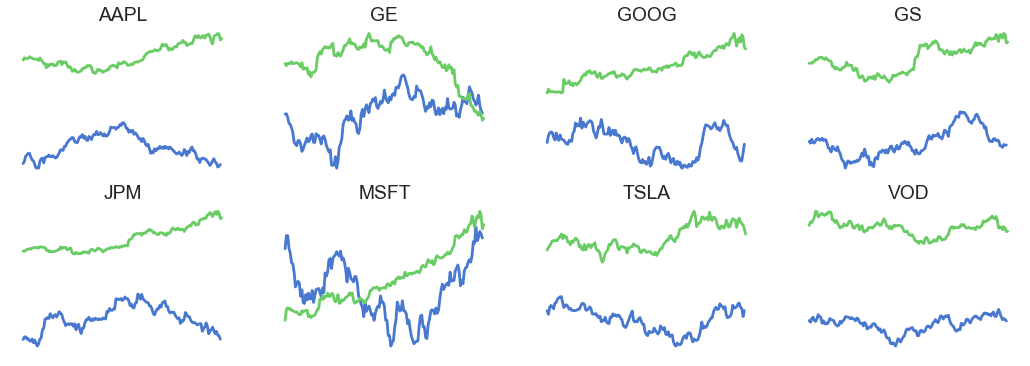

In [8]:
# time-series plots
fig, axes = plt.subplots(nrows=2, ncols=int(prices.shape[1] / 2), figsize=(18.0, 6.0))
for j, (ax, ts) in enumerate(zip(axes.flatten(), prices_gen.T)):
    ax.plot(ts, label="AAFT")
    ax.plot(prices.values[:, j], label="Original")
    ax.set_title(prices.columns[j])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off');

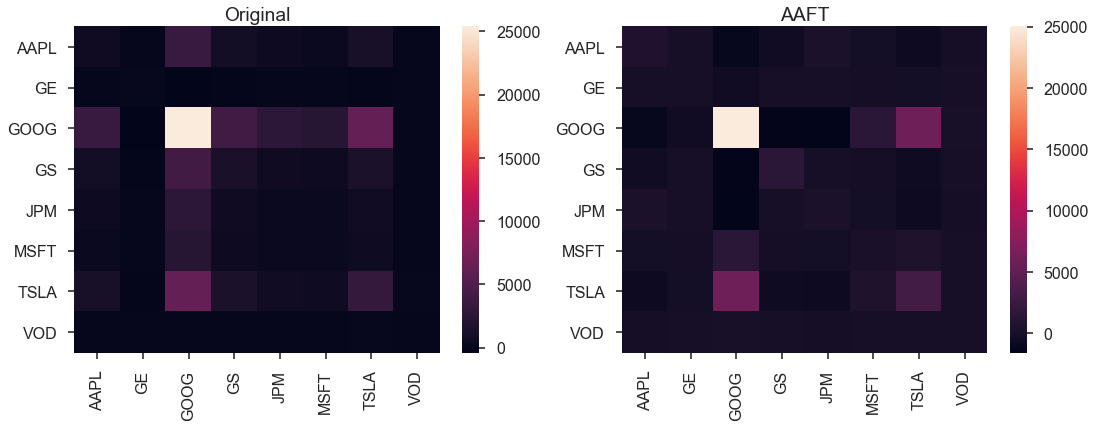

In [9]:
# statistical tests: covariances
fig, axes = plt.subplots(ncols=2, figsize=(18.0, 6.0))
sns.heatmap(np.cov(prices.values.T), ax=axes[0])
axes[0].set_title("Original")
axes[0].set_xticklabels(prices.columns, rotation=90)
axes[0].set_yticklabels(prices.columns, rotation=0)
sns.heatmap(np.cov(prices_gen.T), ax=axes[1])
axes[1].set_title("AAFT")
axes[1].set_xticklabels(prices.columns, rotation=90)
axes[1].set_yticklabels(prices.columns, rotation=0);

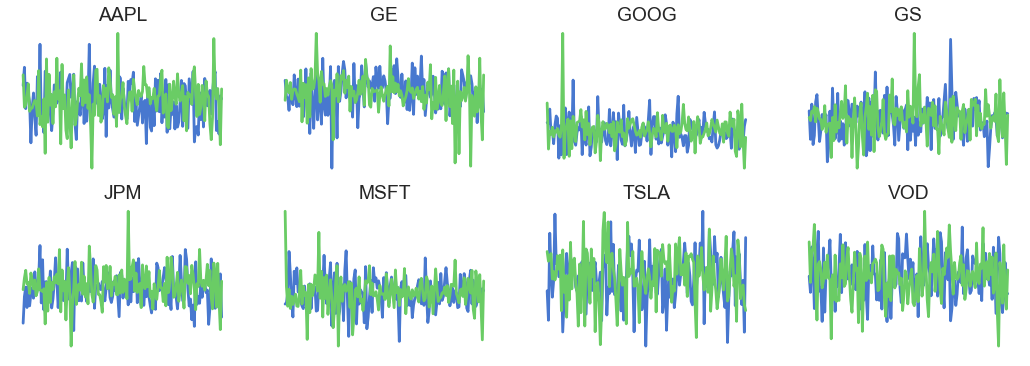

In [10]:
# time-series plots
fig, axes = plt.subplots(nrows=2, ncols=int(returns.shape[1] / 2), figsize=(18.0, 6.0))
for j, (ax, ts) in enumerate(zip(axes.flatten(), returns_gen.T)):
    ax.plot(ts, label="VAR")
    ax.plot(returns.values[:, j], label="Original")
    ax.set_title(returns.columns[j])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off');

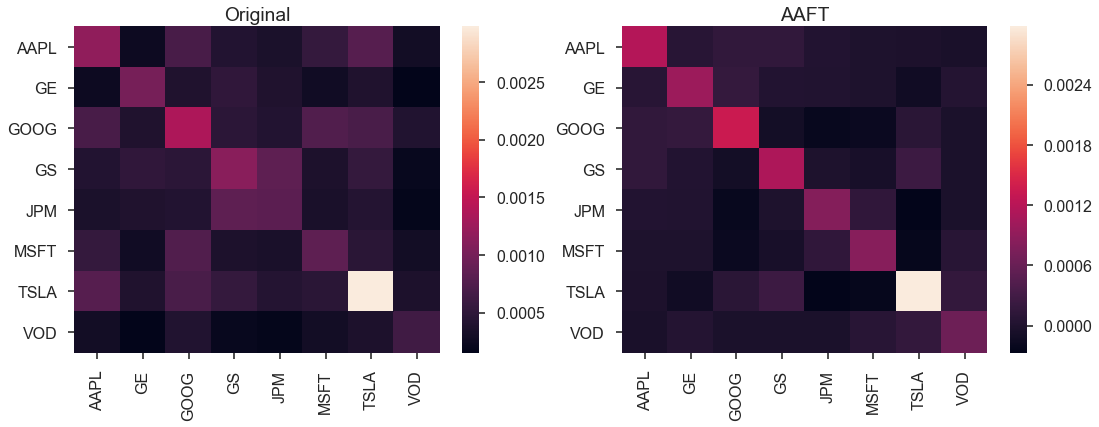

In [11]:
# statistical tests: covariances
fig, axes = plt.subplots(ncols=2, figsize=(18.0, 6.0))
sns.heatmap(np.cov(returns.values.T), ax=axes[0])
axes[0].set_title("Original")
axes[0].set_xticklabels(returns.columns, rotation=90)
axes[0].set_yticklabels(returns.columns, rotation=0)
sns.heatmap(np.cov(returns_gen.T), ax=axes[1])
axes[1].set_title("AAFT")
axes[1].set_xticklabels(returns.columns, rotation=90)
axes[1].set_yticklabels(returns.columns, rotation=0);

### Vector Autoregressive Process (VAR)

We are interested in modeling a $T \times K$ multivariate time series $Y$,
where $T$ denotes the number of observations and $K$ the number of variables.
One way of estimating relationships between the time series and their lagged values is
the **Vector Autoregression (VAR) Process**:

\begin{aligned}
    Y_{t}   &= A_{1} Y_{t-1} + A_{2} + Y_{t-2} + \ldots + A_{p} + Y_{t-p} + u_{t}\\
            &= \sum_{i=1}^{p} A_{i} Y_{t-i} + u_{t}\\
            & u_{t} \sim \text{Normal}(0, \Sigma_{u})
\end{aligned}

where $A_{i} \in R^{K \times K}$ a coefficient matrix.

In [12]:
# returns time-series generation
returns_gen = qtrader.envs.simulator.VAR(returns, 5)

                 VAR Order Selection                 
           aic          bic          fpe         hqic
-----------------------------------------------------
0      -58.19*      -58.03*   5.369e-26*      -58.12*
1       -57.76       -56.31    8.217e-26       -57.17
2       -57.31       -54.57    1.301e-25       -56.20
3       -56.93       -52.90    1.938e-25       -55.29
4       -56.61       -51.29    2.748e-25       -54.45
5       -56.30       -49.68    3.992e-25       -53.61
* Minimum



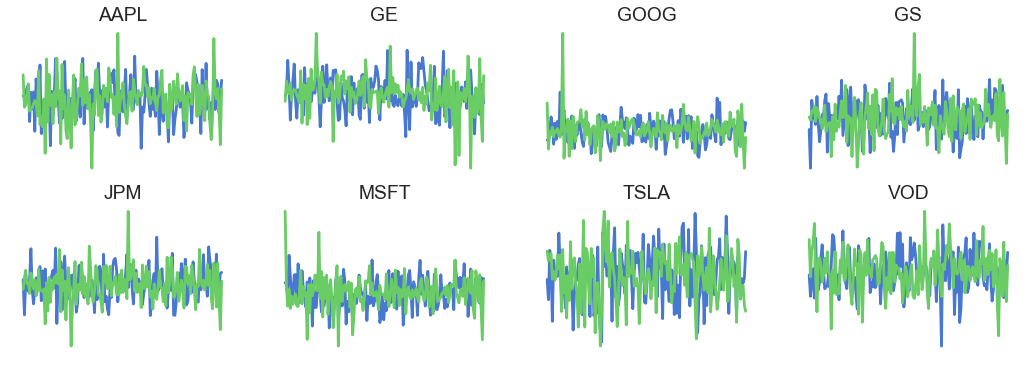

In [13]:
# time-series plots
fig, axes = plt.subplots(nrows=2, ncols=int(returns.shape[1] / 2), figsize=(18.0, 6.0))
for j, (ax, ts) in enumerate(zip(axes.flatten(), returns_gen.T)):
    ax.plot(ts, label="VAR")
    ax.plot(returns.values[:, j], label="Original")
    ax.set_title(returns.columns[j])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off');

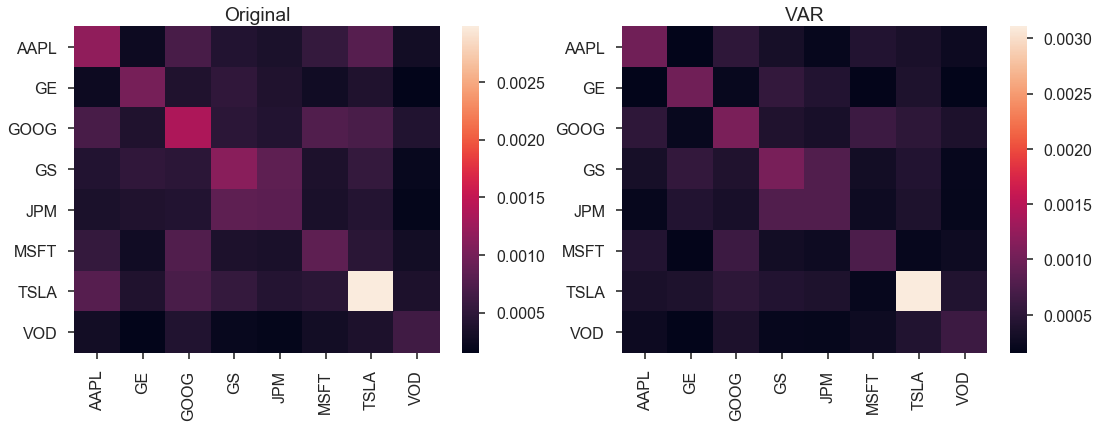

In [14]:
# statistical tests: covariances
fig, axes = plt.subplots(ncols=2, figsize=(18.0, 6.0))
sns.heatmap(np.cov(returns.values.T), ax=axes[0])
axes[0].set_title("Original")
axes[0].set_xticklabels(returns.columns, rotation=90)
axes[0].set_yticklabels(returns.columns, rotation=0)
sns.heatmap(np.cov(returns_gen.T), ax=axes[1])
axes[1].set_title("VAR")
axes[1].set_xticklabels(returns.columns, rotation=90)
axes[1].set_yticklabels(returns.columns, rotation=0);